# Deep Learning with OpenCV
**Satya Mallick, LearnOpenCV.com**

# Realtime Multi-Person 2D Pose Estimation using Part Affinity Fields (2017)
arXiv:1611.08050v2 [cs.CV] 14 Apr 2017
![Open_Pose](OpenPose_Figure.png)

# Highlights 
1. Train elsewhere, perform inference in an OpenCV application

2. Supports **Caffe**, **Tensorflow**, **Torch** and **Darknet**.

3. **Supported layers** : AbsVal, AveragePooling, BatchNormalization, Concatenation, Convolution (including dilated convolution), Crop, Deconvolution, DetectionOutput (SSD-specific layer), Dropout, Eltwise (+, *, max), Flatten, FullyConnected, LRN, LSTM, MaxPooling, MaxUnpooling, MVN, NormalizeBBox (SSD-specific layer), Padding, Permute, Power, PReLU (including ChannelPReLU with channel-specific slopes), PriorBox (SSD-specific layer), ReLU, RNN, Scale, Shift, Sigmoid, Slice, Softmax, Split, TanH
4. Use Caffe model trained on the Multi-Person Image Dataset (MPI) to demonstrate human pose estimation for a single person.

In [6]:
DATA_PATH = "/Users/tawate/Library/CloudStorage/OneDrive-SAS/05_CDT_DataScience/data/OpenCV_Course_Data/"
from IPython.display import HTML
HTML("""
<video width=1024 controls>
  <source src="/Users/tawate/Library/CloudStorage/OneDrive-SAS/08_CDT_DataScience/data/OpenCV_Course_Data/Ice_Hockey.mp4" type="video/mp4">
</video>
""")

In [2]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib

# Load a Caffe Model
A typical Caffe Model has two files

1. **Architecture** : Defined in a **.prototxt** file 
2. **Weights** : Defined in **.caffemodel** file

In [3]:
if not os.path.isdir('pose_estimation_model'):
  os.mkdir("pose_estimation_model")    

protoFile = "pose_estimation_model/pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = "pose_estimation_model/pose_iter_160000.caffemodel"

if not os.path.isfile(protoFile):
  # Download the proto file
  urllib.request.urlretrieve('https://raw.githubusercontent.com/CMU-Perceptual-Computing-Lab/openpose/master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt', protoFile)

if not os.path.isfile(weightsFile):
  # Download the model file
  urllib.request.urlretrieve('http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/mpi/pose_iter_160000.caffemodel', weightsFile)

In [4]:
nPoints = 15 #number of points in model
POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ] #linkage pairs within human anatomy. 0 = head.

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Read Image

In [7]:
im = cv2.imread(DATA_PATH+"Tiger_Woods_Crop.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
inWidth = im.shape[1]
inHeight = im.shape[0]


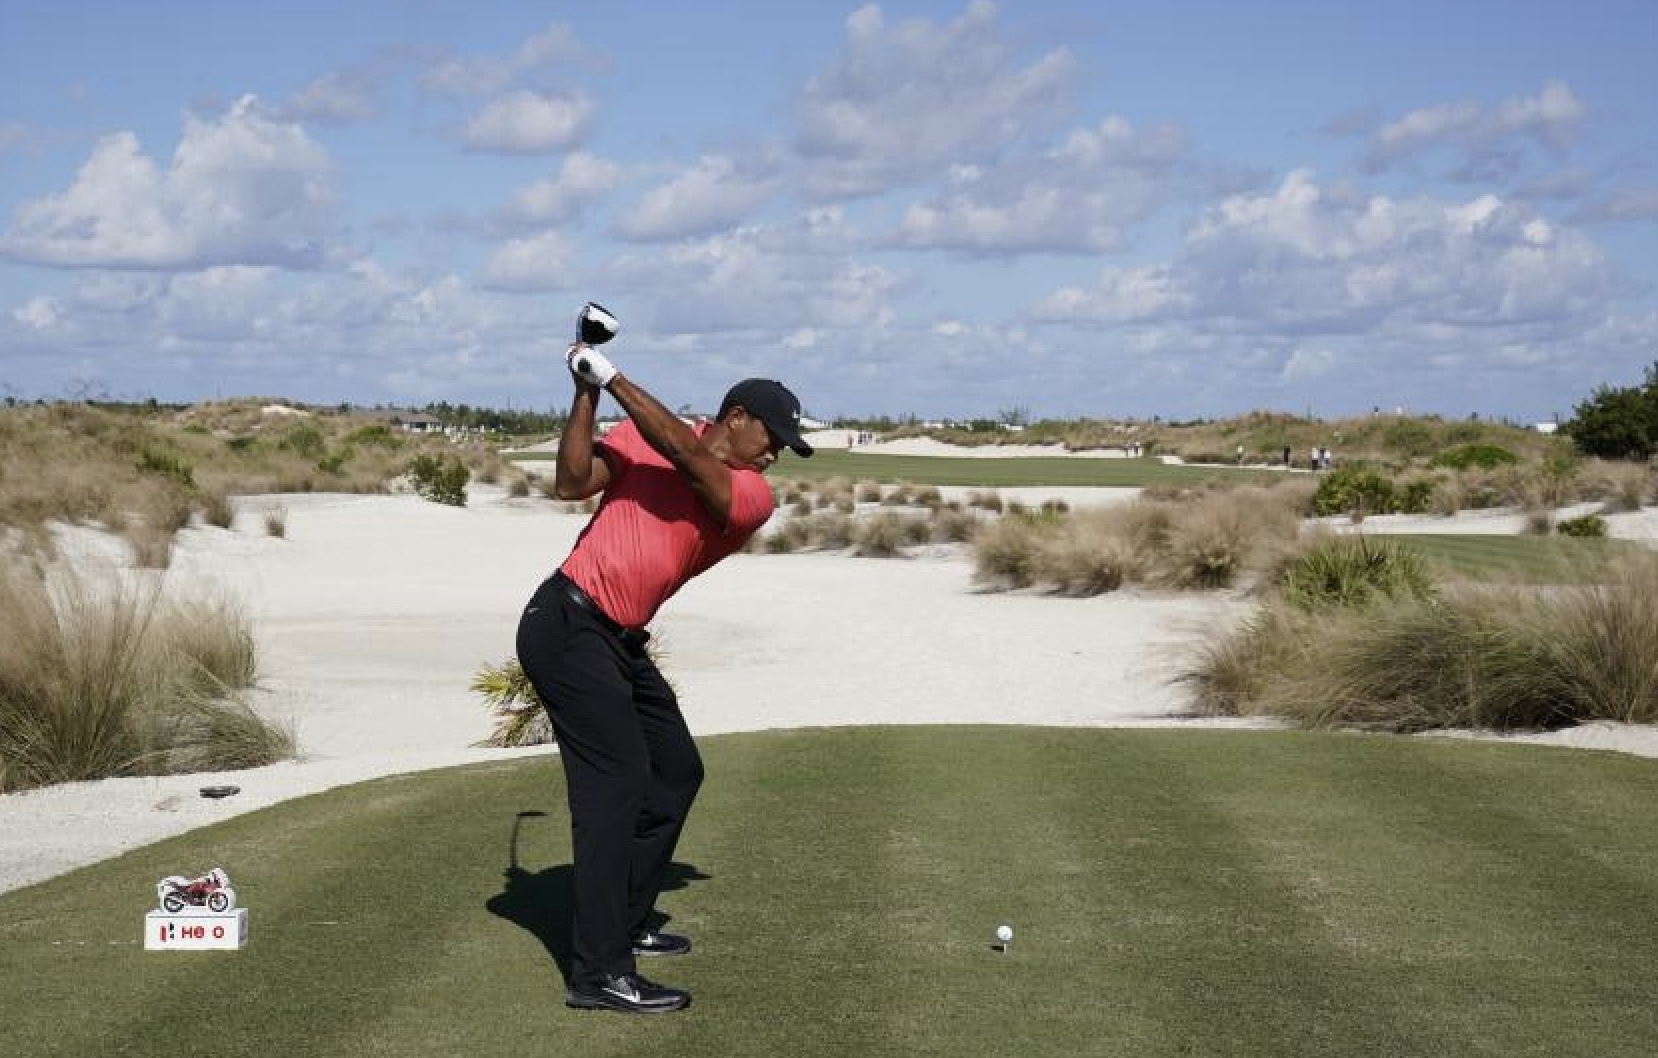

In [8]:
from IPython.display import Image
Image(filename=DATA_PATH+'Tiger_Woods.png') 

# Convert image to blob

In [9]:
netInputSize = (368, 368)
inpBlob = cv2.dnn.blobFromImage(im, 1.0 / 255, netInputSize, (0, 0, 0), swapRB=True, crop=False) # create blob representation
net.setInput(inpBlob)

# Run Inference (forward pass)

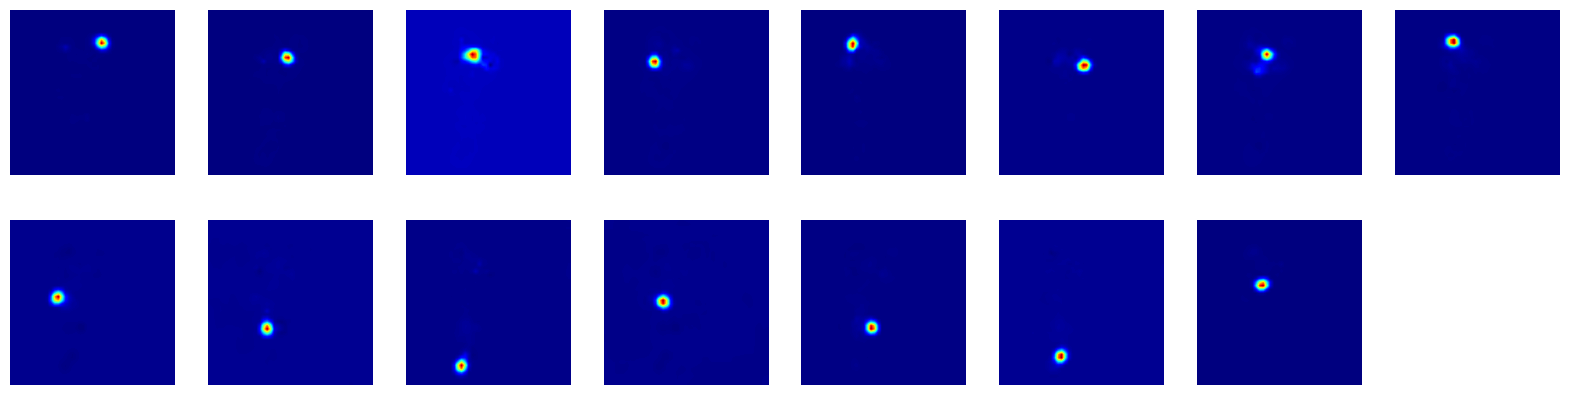

In [10]:
# Forward Pass
output = net.forward() #returns confidence maps and affinity fields for key point detection

# Display probability maps. Key points are denoted by red for yes blue for no. One map for each linkage. Key point 0 refers to head.
plt.figure(figsize=(20,5))
for i in range(nPoints):
    probMap = output[0, i, :, :]
    displayMap = cv2.resize(probMap, (inWidth, inHeight), cv2.INTER_LINEAR)
    plt.subplot(2, 8, i+1); plt.axis('off'); plt.imshow(displayMap, cmap='jet')

# Extract points

In [11]:
# Scale maps to size of the images
# X and Y Scale
scaleX = inWidth / output.shape[3]
scaleY = inHeight / output.shape[2]

# Empty list to store the detected keypoints
points = []

# Treshold 
threshold = 0.1

for i in range(nPoints):
    # Obtain probability map
    probMap = output[0, i, :, :]
    
    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = scaleX * point[0]
    y = scaleY * point[1]

    if prob > threshold : 
        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)


# Display Points & Skeleton

In [12]:
imPoints = im.copy() # copies of input images
imSkeleton = im.copy()
# Draw points. Draw circle location/size and keypoint identifier (0-15)
for i, p in enumerate(points):
    cv2.circle(imPoints, p, 8, (255, 255,0), thickness=-1, lineType=cv2.FILLED)
    cv2.putText(imPoints, "{}".format(i), p, cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, lineType=cv2.LINE_AA)

# Draw skeleton. Draws line from point to point
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(imSkeleton, points[partA], points[partB], (255, 255,0), 2)
        cv2.circle(imSkeleton, points[partA], 8, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)



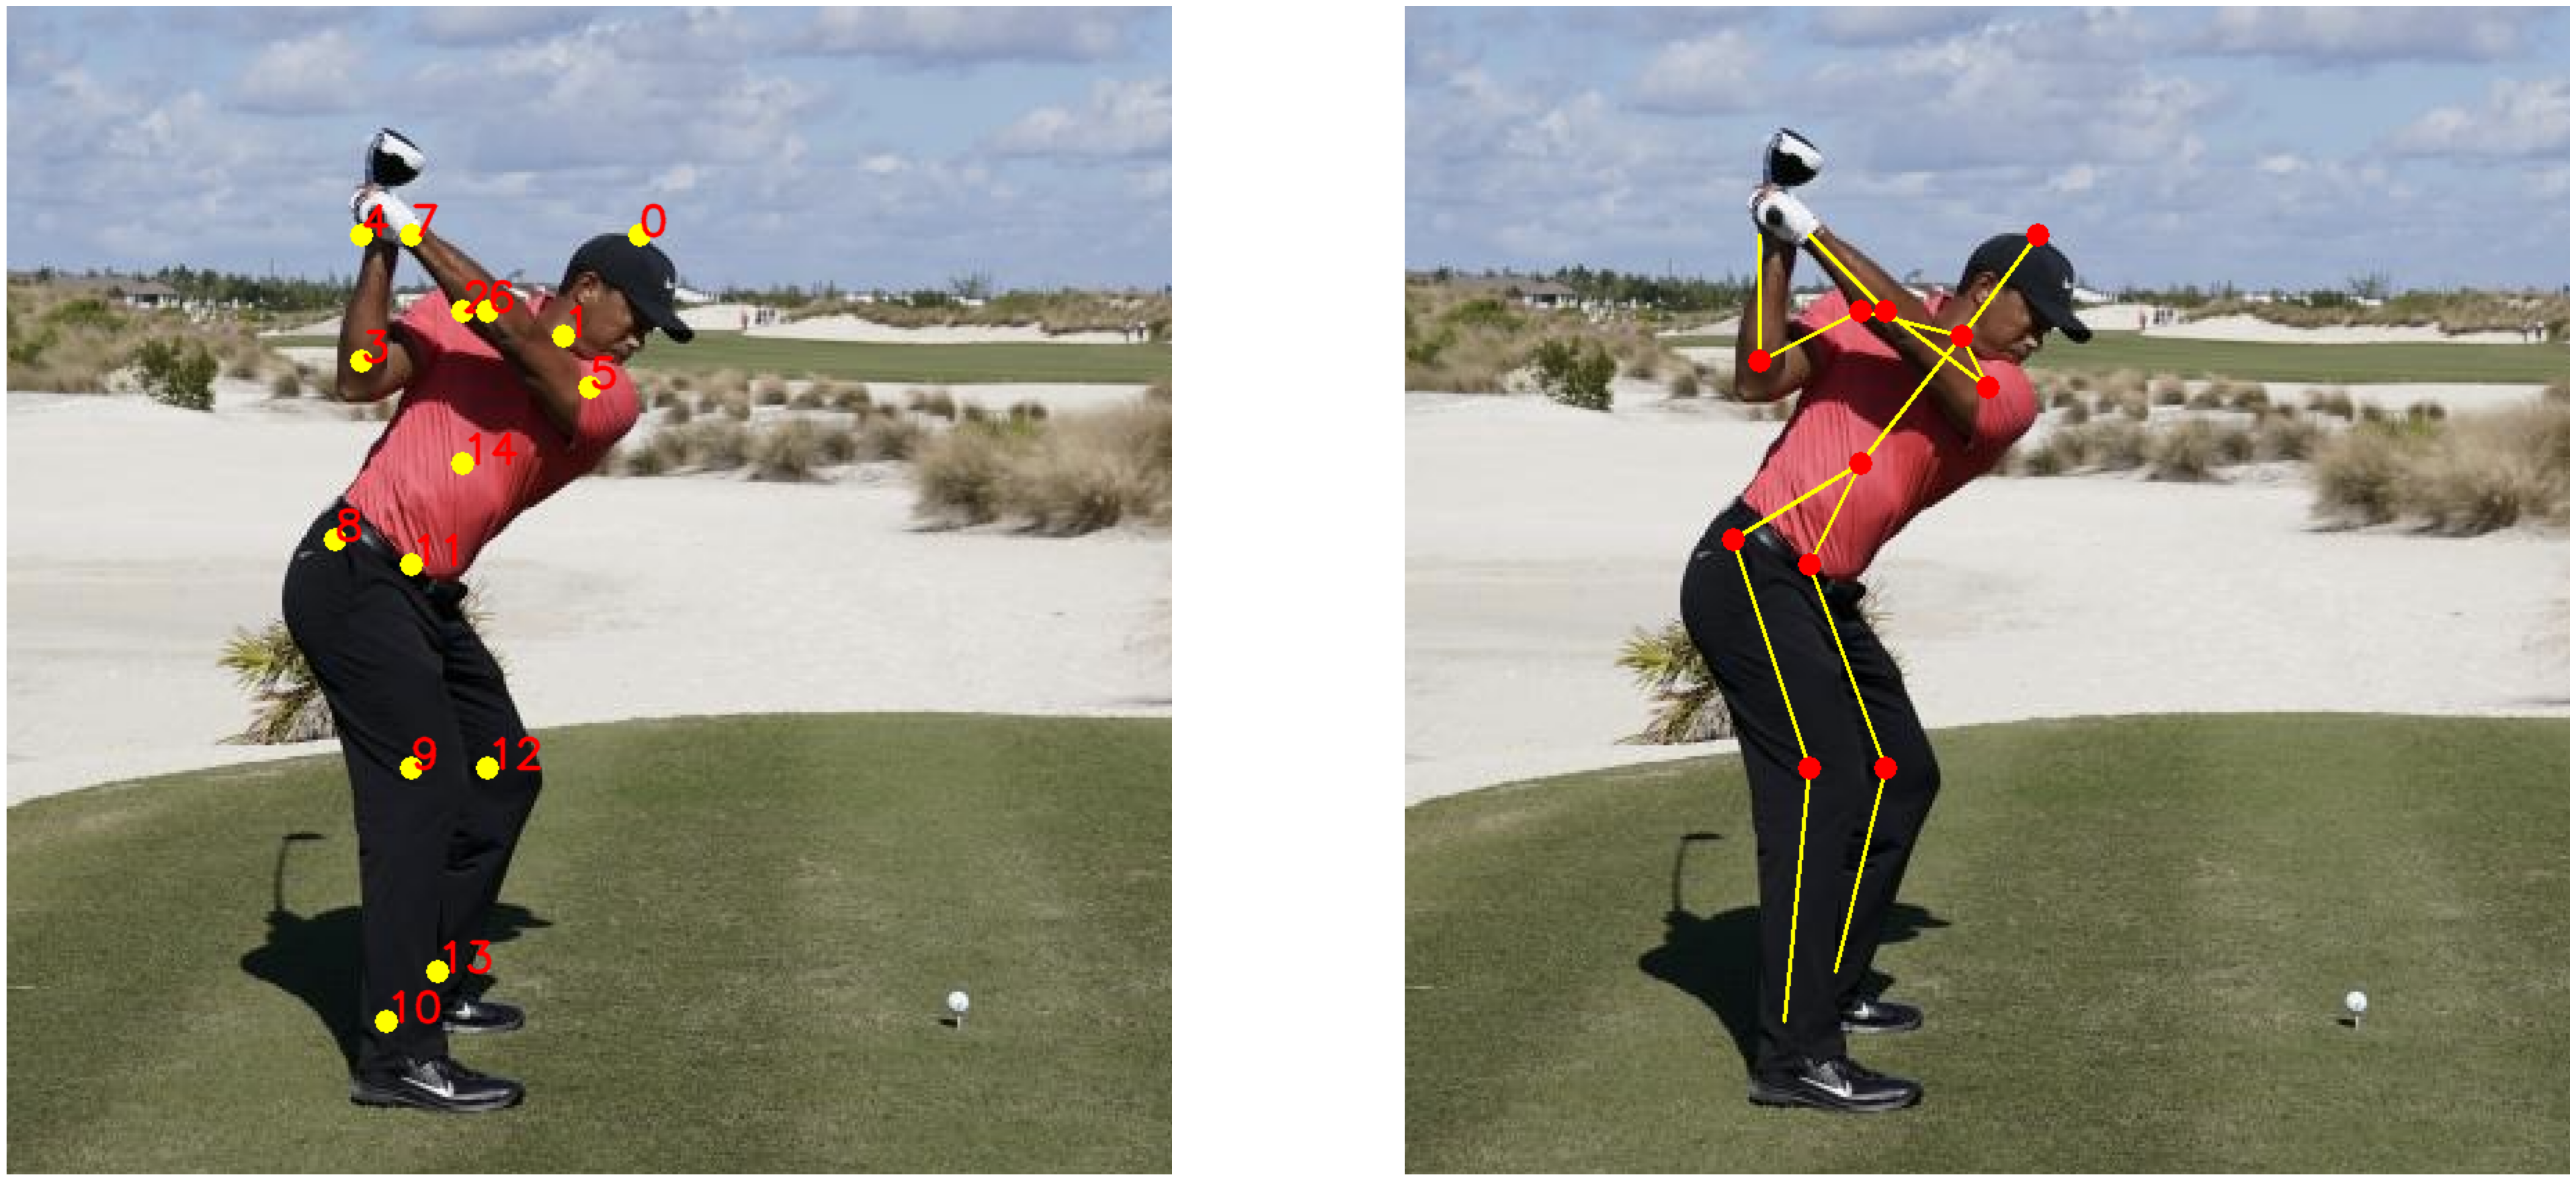

In [13]:
plt.figure(figsize=(50,50))
plt.subplot(121); plt.axis('off'); plt.imshow(imPoints);
plt.subplot(122); plt.axis('off'); plt.imshow(imSkeleton);

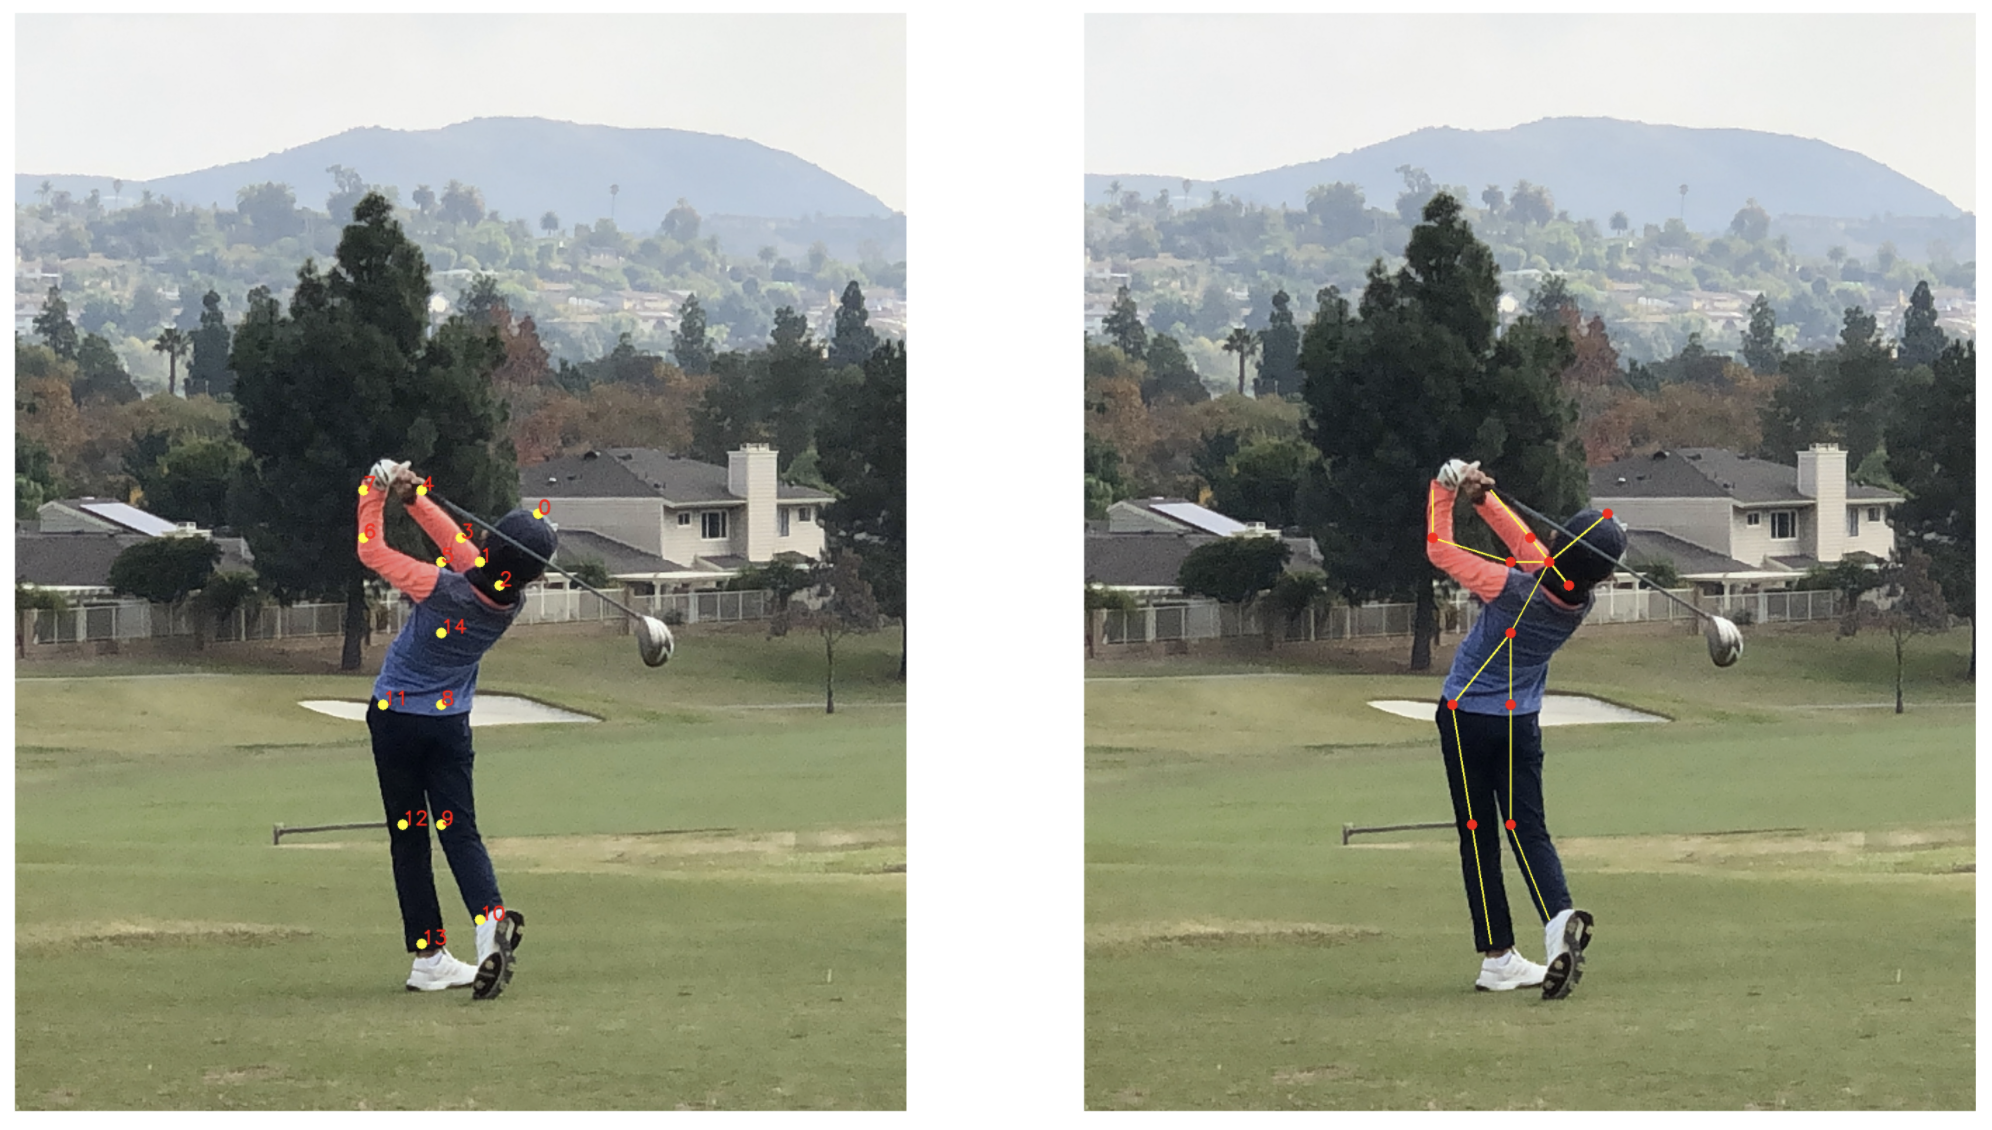

In [12]:
Image(filename='Milton_Golf_Swing.png') 

# Thank You!